# Assignment Phase 2

* **Group Name**: Group 84
* **Group Members**:
	*	Akshay Sharma (S3815250)
	*	Drashti Khakhi (S3815974)
	*	Nikhil Sharma (S3833151)

## Table of content
* [Task 1: Introduction](#introduction)
	*	[Task 1.1: Report Overview](#reportoverview)
	*	[Task 1.2: Overview of Methodology](#methodology) <br> <br>
* [Task 2: Predictive Modelling](#predictivemodelling) <br> <br>
	*	[Task 2.1: Feature Selection](#featureselection)
	*	[Task 2.2: Model Fitting & Tuning](#modelfitting) 
    *	[Task 2.3: Model Comparison](#modelcomparison)<br> <br>
* [Task 3: Critique and Limitations](#limitations)<br> <br>
* [Task 4: Summary and Conclusions](#summary) 
	* [Task 4.1: Project Summary](#projectsummary)
	* [Task 4.2: Summary of Findings](#summary-of-findings)
	* [Task 4.3: Conclusions](#conclusions)

#### Importing Packages

In [1]:
# Set a seed value
seed_value = 999 
# 1. Initialise `PYTHONHASHSEED` environment variable
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Initialise Python's own pseudo-random generator
import random
random.seed(seed_value)
# 3. Initialise Numpy's pseudo-random generator
import numpy as np
np.random.seed(seed_value)


#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
n_jobs = -1
RANDOM_STATE = 999

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

### Reading & Preprocessing Data 

In [2]:
#Reading the dataset
df = pd.read_csv('train.csv',encoding='unicode_escape')

#Sampling to select random 5000 rows
sampled_df = df.sample(5000)

# Removing the 'Unnamed: 0' and 'id' columns
sampled_df.drop(['Unnamed: 0','id'], axis = 1, inplace = True)

# Changing data types of columns from 'Inflight wifi service' to 'Cleanliness'
for i in range(6,20):
    sampled_df.iloc[:,i] = pd.Categorical(sampled_df.iloc[:,i],[0,1,2,3,4,5], ordered=True) 
    
# Deleing the NA values from the dataswet
sampled_df.dropna(axis =0, inplace = True)

# converting the 'Arrival Delay in Minutes' column to int64
sampled_df['Arrival Delay in Minutes'] = sampled_df['Arrival Delay in Minutes'].astype('int64')

# For better understanding, have renamed the level from 'Neutral or dissatisfied' to 'dissatisfied'
sampled_df.replace(to_replace ="neutral or dissatisfied",
                 value ="dissatisfied", inplace = True)

#Converting to Uppercase
for i in range(len(list(sampled_df.columns))):
    if sampled_df.iloc[:,i].dtypes == object:
        sampled_df.iloc[:,i] = sampled_df.iloc[:,i].str.upper()

In [3]:
#Viewing the result
sampled_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
49734,FEMALE,LOYAL CUSTOMER,52,BUSINESS TRAVEL,BUSINESS,2367,2,2,2,2,5,5,5,5,5,5,5,5,5,3,101,93,SATISFIED
50344,MALE,LOYAL CUSTOMER,46,PERSONAL TRAVEL,ECO,414,0,4,0,2,4,0,4,4,3,3,1,4,2,4,0,0,SATISFIED
89920,MALE,LOYAL CUSTOMER,56,BUSINESS TRAVEL,ECO,1072,4,5,5,5,4,4,4,4,2,3,4,4,3,4,68,47,DISSATISFIED
60141,FEMALE,LOYAL CUSTOMER,60,BUSINESS TRAVEL,BUSINESS,2071,2,2,2,2,5,5,4,4,4,4,4,5,4,5,4,0,SATISFIED
30363,MALE,DISLOYAL CUSTOMER,25,BUSINESS TRAVEL,ECO,1012,1,1,1,4,3,1,3,3,3,5,4,2,3,3,9,0,DISSATISFIED


## Task 1 : Introduction <a class="anchor" id="introduction"></a>

### Task 1.1 - Report Overview <a class="anchor" id="reportoverview"></a>

This report includes importing all the necessary packages first. In order to be in line with the Phase 1 report which includes all the data pre processing steps, performed the same steps here so that we can use the same data. After all the preprocessing is completed, performed the Predictive Modeling with original features and the top 5 features(using feature selection). The result was better by selecting top 5 features. After that performed hyper parameter tuning to select the best parameters for better results. To compare the algorithms' performance, Model Comparison was done using paired t-test.

### Task 1.2 - Overview of Methodology <a class="anchor" id="methodology"></a>

The methodology used for predictive modeling is as follows:
1. Feature Selection to get top 5 features
2. Predictive Modeling using all the features in the dataset
3. Predictive Modeling using top 5 features in the dataset
4. Hyper Parameter Tuning 
5. Model Comparison

# Task 2 : Predictive Modelling <a class="anchor" id="predictivemodelling"></a>

In [4]:
#Separating the target variable from the dataset
y = pd.DataFrame(sampled_df.pop('satisfaction'))
X = sampled_df

In [5]:
#Performing One Hot Encoding for respective columns
X['Male'] = pd.get_dummies(df['Gender'], drop_first=True)
X['disloyal Customer'] = pd.get_dummies(df['Customer Type'], drop_first=True)
X['Personal Travel'] = pd.get_dummies(df['Type of Travel'], drop_first=True)
X[['Eco', 'Eco Plus']] = pd.get_dummies(df['Class'], drop_first=True)
X.drop(['Gender', 'Customer Type', 'Type of Travel', 'Class'], axis = 1, inplace=True)
y.replace('SATISFIED', 1, inplace=True)
y.replace('DISSATISFIED', 0, inplace=True)

### Task 2.1 - Feature Selection <a class="anchor" id="featureselection"></a>

Feature: 0, Score: 0.03891
Feature: 1, Score: 0.04096
Feature: 2, Score: 0.12957
Feature: 3, Score: 0.01661
Feature: 4, Score: 0.04243
Feature: 5, Score: 0.01511
Feature: 6, Score: 0.01652
Feature: 7, Score: 0.17056
Feature: 8, Score: 0.05259
Feature: 9, Score: 0.05628
Feature: 10, Score: 0.03221
Feature: 11, Score: 0.04365
Feature: 12, Score: 0.02388
Feature: 13, Score: 0.02546
Feature: 14, Score: 0.02378
Feature: 15, Score: 0.02571
Feature: 16, Score: 0.01421
Feature: 17, Score: 0.01593
Feature: 18, Score: 0.00587
Feature: 19, Score: 0.02774
Feature: 20, Score: 0.10109
Feature: 21, Score: 0.07578
Feature: 22, Score: 0.00515


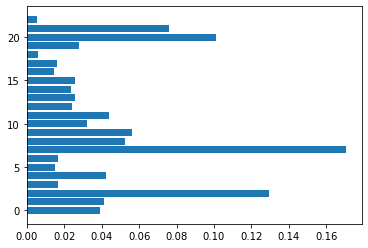

In [6]:
#Feature Selection

colNames = X.columns.tolist()
featureImportance = {}

# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    featureImportance[colNames[i]] = v
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.barh([x for x in range(len(importance))], importance)
pyplot.show()

In [7]:
#Displaying respective features and their importance
featureImportance

{'Age': 0.03891155801209103,
 'Flight Distance': 0.04096411964712164,
 'Inflight wifi service': 0.12956896888317018,
 'Departure/Arrival time convenient': 0.016610137496779986,
 'Ease of Online booking': 0.042432388351913194,
 'Gate location': 0.01510761749449034,
 'Food and drink': 0.016516760759508933,
 'Online boarding': 0.17055545960852478,
 'Seat comfort': 0.05259198597695583,
 'Inflight entertainment': 0.056276123639175814,
 'On-board service': 0.03221119898283761,
 'Leg room service': 0.04365321509687801,
 'Baggage handling': 0.023884756165678433,
 'Checkin service': 0.025455662415143777,
 'Inflight service': 0.02377954135362975,
 'Cleanliness': 0.02571148121480328,
 'Departure Delay in Minutes': 0.014205452329851743,
 'Arrival Delay in Minutes': 0.015927569190251952,
 'Male': 0.005870965441180764,
 'disloyal Customer': 0.027738199787715273,
 'Personal Travel': 0.10109492524662304,
 'Eco': 0.07578114979904904,
 'Eco Plus': 0.005150763106625575}

In [8]:
#Sorting the feature importance in descending order
from operator import itemgetter
sortedFeatureImportance = sorted(featureImportance.items(), key=itemgetter(1), reverse=True)

In [9]:
#Extracting the column names of top 5 features
selectedColumns = []
for i in sortedFeatureImportance[0:5]:
    selectedColumns.append(i[0])

#Displaying the top 5 features
selectedColumns

['Online boarding',
 'Inflight wifi service',
 'Personal Travel',
 'Eco',
 'Inflight entertainment']

In [10]:
#New Data Variable containing selected columns
newX = X[selectedColumns]

#Displaying the new data variable
newX

,Online boarding,Inflight wifi service,Personal Travel,Eco,Inflight entertainment
49734,5,2,0,0,5
50344,0,0,1,1,4
89920,4,4,0,1,4
60141,5,2,0,0,4
30363,1,1,0,1,3
...,...,...,...,...,...
48339,2,2,0,0,1
4100,4,3,0,0,4
3242,3,2,0,0,2
76095,4,0,0,0,1


### Task 2.2 - Model Fitting & Tuning <a class="anchor" id="modelfitting"></a>

### The following predictive modeling has been performed with the original data variable containing all features

In [11]:
#Splitting the training and test data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [12]:
#List of classifiers to be implemented on data
models = [SVC(), KNeighborsClassifier(), RandomForestClassifier(), GaussianNB(), GradientBoostingClassifier()]

In [13]:
#Function which implements different classifiers
def classifier_model(classifier, X, y):
    """
    Function to run a machine learning model on a set of training data and see how well it generalizes on a set of test data.
    Parameters: 
    classifier - a machine learning algorithm like decision tree
    X_train - a subset of training data
    X_test - a subset of training data
    y_train - a subset of test datasubset of test data
    y_test - a 
    Returns:
    prediction:(numpy array) - A numpy array containing the predicted values
    accuracy: (float) - The accuracy of the model
    """
    scores = cross_val_score(classifier, X, y, cv=5)
    scores
    return round(sum(scores/5),3)

In [14]:
for model in models:
    print(f'Model Name: {str(model)}, Score: {classifier_model(model, X, y)}')

Model Name: SVC(), Score: 0.663
Model Name: KNeighborsClassifier(), Score: 0.644
Model Name: RandomForestClassifier(), Score: 0.942
Model Name: GaussianNB(), Score: 0.859
Model Name: GradientBoostingClassifier(), Score: 0.94


### The following predictive modeling has been performed with the new data variable containing only top 5 features

In [15]:
X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size = .2)

In [16]:
for model in models:
    print(f'Model Name: {str(model)}, Score: {classifier_model(model, newX, y)}')

Model Name: SVC(), Score: 0.916
Model Name: KNeighborsClassifier(), Score: 0.899
Model Name: RandomForestClassifier(), Score: 0.924
Model Name: GaussianNB(), Score: 0.85
Model Name: GradientBoostingClassifier(), Score: 0.914


### HyperParameter Tuning

In [17]:
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13],
              'p': [1, 2]}

rf_param_grid = {'n_estimators': [100, 200],
                'max_features': ['auto', 'sqrt', 'log2'],
                'criterion': ['gini', 'entropy']}

nb_params = {'var_smoothing': [1e-9, 1e-10, 1e-11, 1e-12]}

svm_params = {'C': [1, 10, 100],
             'kernel': ['rbf', 'linear'],
             'gamma': ['scale', 'auto']}

xg_params = {
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.1, 0.2, 0.5, 0.7],
        'criterion': ['friedman_mse', 'mse', 'mae'],
        }

knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_params, cv = 5, n_jobs = n_jobs)
   
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv = 5, n_jobs = n_jobs)
    
nb_grid_search = GridSearchCV(GaussianNB(), nb_params, cv = 5, n_jobs = n_jobs)
    
svm_grid_search = GridSearchCV(SVC(), svm_params, cv = 5, n_jobs = n_jobs)
    
xg_grid_search = GridSearchCV(GradientBoostingClassifier(), xg_params, cv = 5, n_jobs = n_jobs)

In [18]:
#Function of classifiers with Hyper parameter tuning

def classifier_model_and_tuning(classifier, X_train, X_test, y_train, y_test, X, y):
    """
    Function to run a machine learning model on a set of training data and see how well it generalizes on a set of test data.
    Parameters: 
    classifier - a machine learning algorithm like decision tree
    X_train - a subset of training data
    X_test - a subset of training data
    y_train - a subset of test datasubset of test data
    y_test - a 
    Returns:
    prediction:(numpy array) - A numpy array containing the predicted values
    accuracy: (float) - The accuracy of the model
    """
    
    if str(classifier) == 'SVC()':
        svm_grid_search.fit(X_train, y_train)
        new_model =  svm_grid_search.best_estimator_
    elif str(classifier) == 'KNeighborsClassifier()':
        knn_grid_search.fit(X_train, y_train)
        new_model = knn_grid_search.best_estimator_
    elif str(classifier) == 'RandomForestClassifier()':
        rf_grid_search.fit(X_train, y_train)
        new_model = rf_grid_search.best_estimator_
    elif str(classifier) == 'GaussianNB()':
        nb_grid_search.fit(X_train, y_train)
        new_model = nb_grid_search.best_estimator_
    else:
        xg_grid_search.fit(X_train, y_train)
        new_model = xg_grid_search.best_estimator_
        
    scores = cross_val_score(new_model, X, y, cv=5)
    return scores

In [19]:
model_scored = {}
for model in models:
    model_scored[model] = classifier_model_and_tuning(model, X_train, X_test, y_train, y_test, newX, y)

In [20]:
for key in model_scored.keys():
    print(key, '->', round(sum(model_scored[key])/5, 3))

SVC() -> 0.923
KNeighborsClassifier() -> 0.909
RandomForestClassifier() -> 0.925
GaussianNB() -> 0.85
GradientBoostingClassifier() -> 0.922


### Task 2.3 - Model Comparison <a class="anchor" id="modelcomparison"></a>

In [21]:
repeatedKStratified_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = RANDOM_STATE)
def plot_roc(model, param, X_train, y_train, X_test, y_test):
    scoring_metric = 'roc_auc'
    gs_model = GridSearchCV(estimator = model, 
                      param_grid = param, 
                      cv = repeatedKStratified_cv,
                      verbose = 1, 
                      scoring = scoring_metric,
                      return_train_score = True,
                      n_jobs=n_jobs)
    
    gs_model.fit(X_train, y_train)
    gs_model_pred = gs_model.predict(X_test)
    
    roc_auc_score(y_test, gs_model_pred)
    
    # Calculating roc score.
    model_prob = gs_model.predict_proba(X_test)
    fpr_model, tpr_model, _ = roc_curve(y_test, model_prob[:, 1])
    roc_auc_model = auc(fpr_model, tpr_model)
    print(roc_auc_model)
    
    # Creating dataframe containing TPR and FPR
    model_roc = pd.DataFrame({"TPR": tpr_model, "FPR": fpr_model})

    # Plotting ROC curve
    plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(model_roc['FPR'], model_roc['FPR'], color='green', linestyle='--')
    plt.plot(model_roc['FPR'], model_roc['TPR'], color='blue')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {str(model)}')
    plt.grid(True, linewidth=1)

    plt.show()

Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   59.0s finished


0.9603324081416864


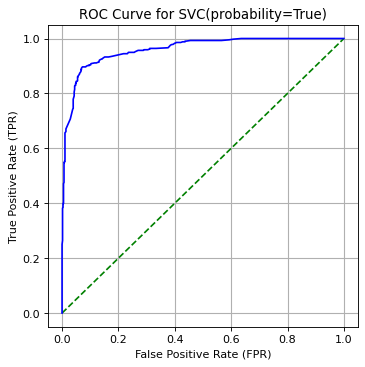

In [22]:
plot_roc(SVC(probability=True), svm_params, X_train, y_train, X_test, y_test)

Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s


0.953122934840074


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.3s finished


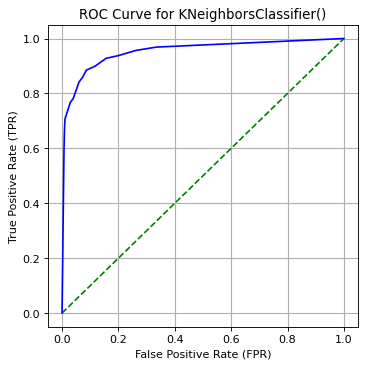

In [23]:
plot_roc(KNeighborsClassifier(), knn_params, X_train, y_train, X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   10.3s finished


0.9674241673275179


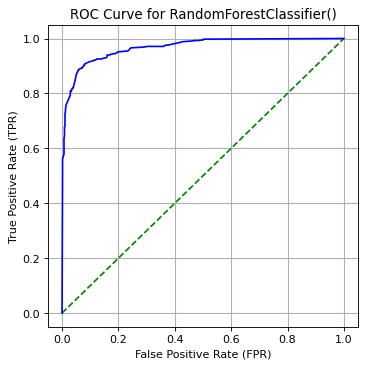

In [24]:
plot_roc(RandomForestClassifier(), rf_param_grid, X_train, y_train, X_test, y_test)

Fitting 15 folds for each of 4 candidates, totalling 60 fits
0.9016405630452022


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished


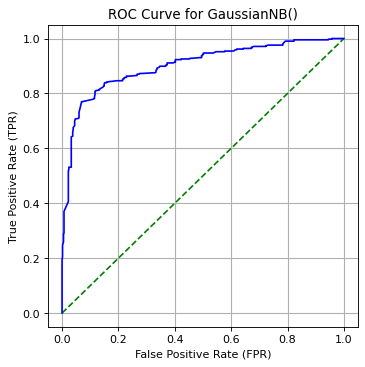

In [25]:
plot_roc(GaussianNB(), nb_params, X_train, y_train, X_test, y_test)

Fitting 15 folds for each of 24 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.5min finished


0.9720294739624636


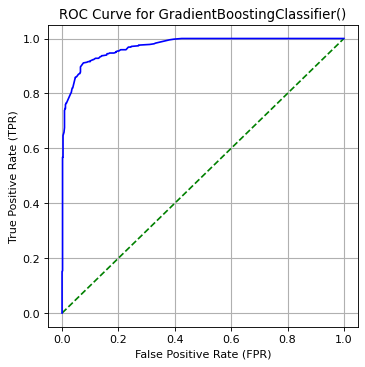

In [26]:
plot_roc(GradientBoostingClassifier(), xg_params, X_train, y_train, X_test, y_test)

In [27]:
for outer_key in model_scored.keys():
    for inner_key in model_scored.keys():
        if(outer_key!=inner_key):
            print(f'Comparison between {outer_key} and {inner_key}. Result is {stats.ttest_rel(model_scored[outer_key], model_scored[inner_key]).pvalue.round(8)}')


Comparison between SVC() and KNeighborsClassifier(). Result is 0.00505768
Comparison between SVC() and RandomForestClassifier(). Result is 0.1215206
Comparison between SVC() and GaussianNB(). Result is 0.00010744
Comparison between SVC() and GradientBoostingClassifier(). Result is 0.74048598
Comparison between KNeighborsClassifier() and SVC(). Result is 0.00505768
Comparison between KNeighborsClassifier() and RandomForestClassifier(). Result is 0.01171125
Comparison between KNeighborsClassifier() and GaussianNB(). Result is 0.00066439
Comparison between KNeighborsClassifier() and GradientBoostingClassifier(). Result is 0.00441252
Comparison between RandomForestClassifier() and SVC(). Result is 0.1215206
Comparison between RandomForestClassifier() and KNeighborsClassifier(). Result is 0.01171125
Comparison between RandomForestClassifier() and GaussianNB(). Result is 7.854e-05
Comparison between RandomForestClassifier() and GradientBoostingClassifier(). Result is 0.26622945
Comparison be

# Task 3 - Critique & Limitations

Strengths:
1. We noticed that after doing feature selection, ideally the model should give less accuracy if the number of features are reduced, but as top 5 features were selected which are very impactful, the model gives better result as compared to using all features.
2. Used GridSearchCV for selecting best model parameters which uses all the combinations of the given parameters. To save the computation cost of GridSearchCV, we have performed hyper parameter tuning after selecting the features which would reduce the complexity dimension of the dataset.
3. Performed GridSearchCV on all the models which gives the best model estimator and hence comparison made between models will be fair.

Weaknesses:
1. The dataset that we selected contained around 100k rows, but due to the restrictions given, sampled only 5k rows. Due to this reason, accurate result of models cannot be obtained. 
2. If larger dataset is used, models can perform better. 
3. When hyper parameter tuning was performed, used only top 5 features selected from feature selection which can also deteriorate the result. 
4. In the process of feature selection, we ended up using Random Forest Importance methods. We could have avoided this, by using a wrapper which would have helped in determining the best feature selection method.

# Task 4 - Summary & Conclusions <a class="anchor" id="summary"></a>

### Task 4.1 - Project Summary <a class="anchor" id="projectsummary"></a>

After doing exploratory data analysis in phase 1, we found out that the customer satisfation depends on services like On-board service, Food & Drink, Cleanliness, Inflight entertainment, Online boarding, Seat Comfort, Leg Room. But when we did feature engineering we found that the customer satisfaction is dependent on other services as well.


After preparing the data we moved to the data modeling phase. We took only a sample size of 5000 so we can reduce the computational time which would impact the accuracy of the model & might hide the true depiction of model accuracy.Now, we trained sampled data on various machine learning models, and obtained the best performing model in terms of accuracy which helps in predicting the satisfaction level of customers. Initially, we trained our data in models without hyperparameter tuning, to find a base model score. Random Forest resulted into best accuracy. Secondarily, we performed feature selection to find the minimal feature which have strong linkage with the predicted feature & help us reducing the computing cost with positive impact on the accuracy of the models or even if there is 3-5% of loss in the accuracy there would be significant savings in the computational effectiveness, we observed that few models (KNN) have significantly improved accuracy while there was minimal rise of accuracy in the other models.

### Task 4.2 - Summary of Findings <a class="anchor" id="summary-of-findings"></a>

1. When hyperparameter tuning is performed on 5 models using GridSearchCV to observe if tuning the hyperparameters would improve the accuracy of these models before selecting the best model for our further analysis, we noticed that there wasn’t any significant improvement in the accuracy of the models. 
2. We also analyzed the ROC curve of the best performing model to find TPR & FPR, which would help airline make the right choice & adjusting the balance of TPR & FPR according to their business needs. 
3. Furthermore, we executed a paired t-test on the models with the optimal accuracy. In the end, the XGBoost came on top with the best accuracy score of 92.2% and ROC score of 97.2% on the sampled data. 
4. Random Forest Classifier, SVC, and XGBoost Classifier models were the models which performed the best but when we compare the results using the ROC curve which gives us Information about the false positives rate and true positive rate, the roc score of XGBoost is the highest. We will therfore conclude that the XGBoost classifier is the best classiier model amongst all the models we compared.

### Task 4.3 - Conclusions <a class="anchor" id="conclusions"></a>

Satisfaction rate for any airline is very important. Using this we can see in what all sections the airline is lacking and improve on them. In this report, we found that customer satisfaction can be predicted by mainly 5 features which are 'Online boarding', 'Inflight wifi service', 'Type of Travel', 'Class', 'Inflight entertainment'. So, if an airline wants to improve their satisfaction rating, they need to focus on improving these 5 services. Using our machine learning model, we can get the customer satisfaction rating of any airline we want. We can also help any airline improve their satifaction rating by telling them what service they lack in and need improvement in.

In future, we will be training the model on all the data which consisted of more than 100k records instead of the sample data of 5000 records. Doing this will make the model more accurate and precise. 